# Statistics for WLASL: Unprocessed

In [1]:
import json
from pathlib import Path
from typing import List, Dict, TypedDict, TypeAlias, Literal, Optional
import matplotlib.pyplot as plt
#locals
from configs import WLASL_ROOT, SPLIT_DIR, CLASSES_PATH
from stats import get_split_stats, latex_set_summary_table, latex_class_stats_table, barplot_metric, histogram_metric, AVAIL_SETS, AVAIL_SPLITS, class_stats

## From the WLASL GitHUB page

Data Description
-----------------

* `gloss`: *str*, data file is structured/categorised based on sign gloss, or namely, labels.

* `bbox`: *[int]*, bounding box detected using YOLOv3 of (xmin, ymin, xmax, ymax) convention. Following OpenCV convention, (0, 0) is the up-left corner.

* `fps`: *int*, frame rate (=25) used to decode the video as in the paper.

* `frame_start`: *int*, the starting frame of the gloss in the video (decoding
with FPS=25), *indexed from 1*.

* `frame_end`: *int*, the ending frame of the gloss in the video (decoding with FPS=25). -1 indicates the gloss ends at the last frame of the video.

* `instance_id`: *int*, id of the instance in the same class/gloss.

* `signer_id`: *int*, id of the signer.

* `source`: *str*, a string identifier for the source site.

* `split`: *str*, indicates sample belongs to which subset.

* `url`: *str*, used for video downloading.

* `variation_id`: *int*, id for dialect (indexed from 0).

* `video_id`: *str*, a unique video identifier.


### Additional info:

* The videos come pre-cut from the original youtube videos, therefore, the video_id is essentially a unique identifier for each instance

* There are some issues with the labelling, especially where certain frame start and ends are way too high


### Naming convention:
For the naming of different functions, 'set' and 'split' can somtimes be used interchangibly to mean different things, which can be confusing. So for all code written by me,
* **SPLIT**: A split of WLASL, one of asl100, asl300, asl1000 and asl2000
* **SET**: A subset of a given wlasl split, one of train, val test


## Split

In [2]:
split_dir = Path(WLASL_ROOT) / SPLIT_DIR
splits = [p.name for p in split_dir.iterdir() if p.suffix == '.json']
print(f'Found splits: {splits}')

Found splits: ['asl1000.json', 'all.json', 'asl100.json', 'asl300.json', 'asl2000.json']


In [3]:
# split_name = 'asl100' #change here for different split
split_options = [p.replace('.json', '') for p in splits]
split_name = 'None'
while split_name not in split_options:
    split_name = input(f'Please enter split_name, one of: {", ".join(split_options)}')
print(f'Selected: {split_name}')

Selected: asl100


In [4]:
current_split = json.load(open(split_dir / f'{split_name}.json'))
classes = json.load(open(CLASSES_PATH))

## Output

In [5]:
out_dir = Path('./info/unprocessed')
out_dir.mkdir(parents=True, exist_ok=True)
out_file = out_dir / f'wlasl_{split_name[3:]}_stats.json'
    

## Stats

In [6]:
top_n = 20

In [7]:
wlasl_stats = get_split_stats(current_split)
json.dump(wlasl_stats, open(out_file, 'w'), indent=4)

##### Split stats: 

Statistics for a given split, e.g. asl100

In [8]:
print(latex_set_summary_table(split_name, wlasl_stats))

\begin{table}[h]
        \centering
        \begin{tabular}{lccc}
        \hline
        Set & Instances & Signers & Classes \\
        \hline
        train & 1442 & 91 & 100 \\
val & 338 & 69 & 100 \\
test & 258 & 56 & 100 \\
        \hline
        \end{tabular}
        \caption{Statistics summary for split asl100.}
        \end{table}


### Set

In [9]:
# set_name: AVAIL_SETS = 'train'
set_options = ['train', 'test', 'val']
set_name = 'None'
while set_name not in set_options:
    set_name = input(f'Please enter set_name, one of: {", ".join(set_options)}')
print(f'Selected: {set_name}')

Selected: train


##### Set stats:

Stats for a given set (e.g. train) in a given split (e.g. asl100)

In [10]:
print(latex_class_stats_table(split_name=split_name, set_name=set_name, set_stats_obj=wlasl_stats["per_set_stats"][set_name]))

\begin{table}[h]
        \centering
        \begin{tabular}{lccc}
        \hline
        Gloss & Instances & Signers & Variations \\
        \hline
        book & 30 & 14 & 1 \\
drink & 25 & 15 & 1 \\
computer & 20 & 12 & 3 \\
before & 18 & 13 & 2 \\
chair & 19 & 11 & 1 \\
go & 19 & 13 & 2 \\
clothes & 18 & 10 & 1 \\
who & 18 & 15 & 1 \\
candy & 17 & 13 & 2 \\
cousin & 16 & 10 & 1 \\
deaf & 16 & 12 & 1 \\
fine & 15 & 11 & 2 \\
help & 15 & 10 & 1 \\
no & 15 & 13 & 1 \\
thin & 15 & 13 & 2 \\
walk & 15 & 13 & 1 \\
year & 15 & 12 & 1 \\
yes & 15 & 12 & 1 \\
all & 14 & 12 & 2 \\
black & 15 & 13 & 1 \\
cool & 14 & 8 & 3 \\
finish & 14 & 10 & 2 \\
hot & 15 & 12 & 1 \\
like & 14 & 10 & 2 \\
many & 15 & 11 & 1 \\
mother & 15 & 10 & 1 \\
now & 15 & 10 & 1 \\
orange & 15 & 13 & 1 \\
table & 15 & 10 & 1 \\
thanksgiving & 15 & 11 & 2 \\
what & 14 & 12 & 2 \\
woman & 15 & 10 & 1 \\
bed & 15 & 12 & 1 \\
blue & 15 & 12 & 1 \\
bowling & 15 & 10 & 1 \\
can & 15 & 10 & 1 \\
dog & 14 & 13 & 2 \\
family & 

#### Metric

In [11]:
# set_name: AVAIL_SETS = 'train'
ex_dict = wlasl_stats['per_set_stats'][set_name]['per_class_stats']['book']
metric_options = ex_dict.keys()
metric = 'None'
while metric not in metric_options:
    metric = input(f'Please enter metric, one of: {", ".join(metric_options)}')
print(f'Selected: {metric}')

Selected: num_instances


#### Per class stats:

Stats between individual classes

##### Bar plot

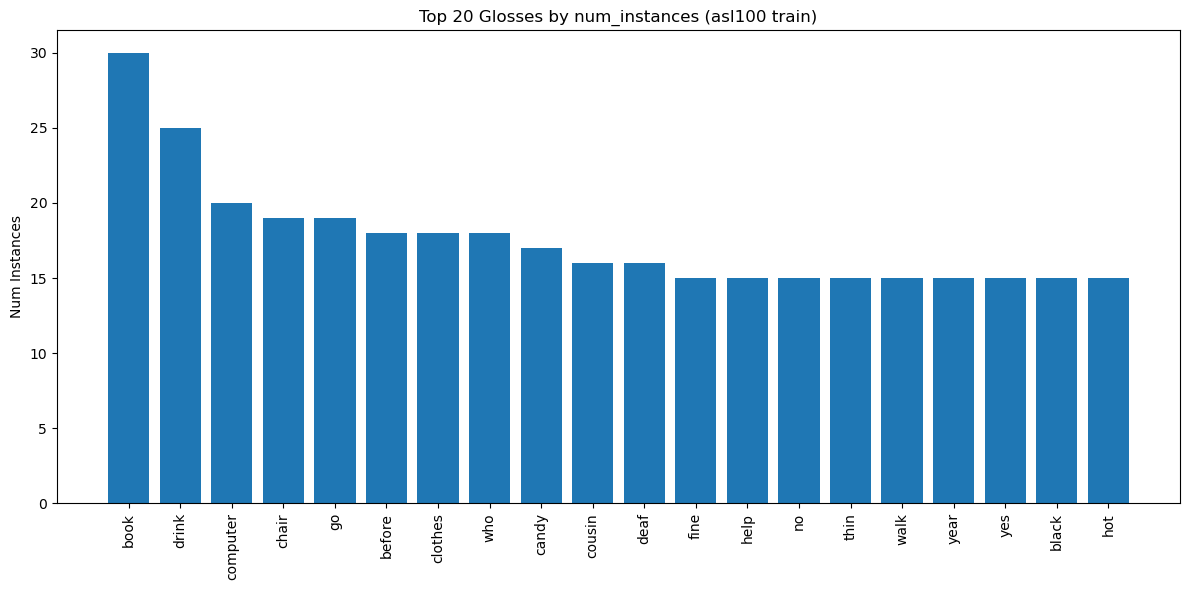

In [12]:
barplot_metric(
    per_class=wlasl_stats["per_set_stats"][set_name]["per_class_stats"],
    metric=metric,
    top_n=top_n,
    title=f"Top {top_n} Glosses by {metric} ({split_name} {set_name})"
)


##### Histogram

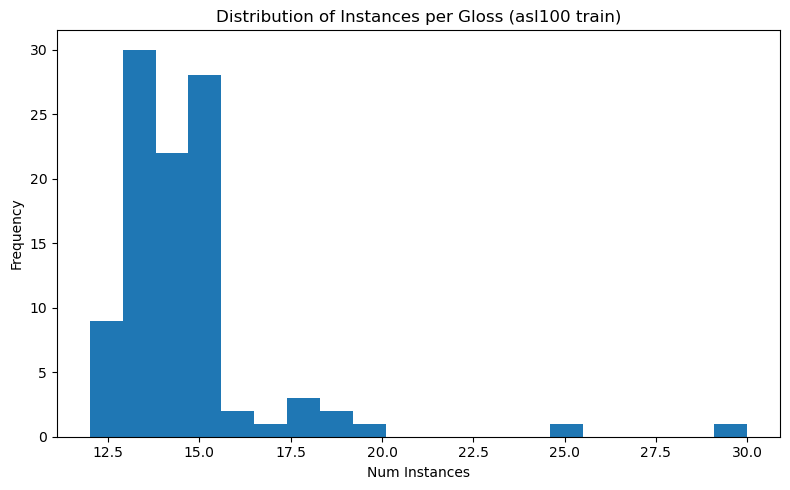

In [13]:
histogram_metric(
    per_class=wlasl_stats["per_set_stats"][set_name]["per_class_stats"],
    metric=metric,
    bins=20,
    title=f"Distribution of Instances per Gloss ({split_name} {set_name})"
)
